DISCLAIMER: Check "model/" folder for the complete code!

# Prerequisites

In [8]:
import sys, os

import torch
import numpy as np

Important paths for the notebook:

In [9]:
homework_root_path = '../../'
data_root_path = '../../data/'

data_train_path = os.path.join( data_root_path , 'train.tsv' )
data_dev_path = os.path.join( data_root_path , 'dev.tsv' )

models_classes_path = '../../model/test2/'
models_saves_path = '../../model/test2/saves/'

In [10]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

Setting the seed for reproducibility:

In [11]:
SEED = 28

# random.seed(SEED) # not used
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

Path:

In [12]:
sys.path.append( models_classes_path )

%load_ext autoreload
%autoreload 2

# Global parameters

These parameters are needed in various classes, so they will be saved so to be used in the final model:

In [59]:
globalParams = {
    'PAD_TOKEN': '<pad>',
    'PAD_INDEX': -1,
    'UNK_TOKEN': '<unk>',
    'window_size': 41,
    'window_shift': 41 - 8
}

# Using GloVe as embedding

After the first test done with "test1", I wanted to check if a bigger vocabulary of words is better than a smaller one (for performances limit reasons) but with a lot of n-grams (FastText implementation). <br>
To do so, a new embedding is created, which uses a pretrained model from the gensim repository: it contains a vocabulary of 400'000 words with the GloVe word vector representation. <br>
The padding and the unknown tokens were added at the extracted embedding layer and also at the vocabulary mappings.

In [16]:
import gensim.downloader as gensim_api

embedding_keyedvectors = gensim_api.load('glove-wiki-gigaword-300')

/home/marco/miniconda3/envs/nlp2022-hw1/lib/python3.9/site-packages/gensim/similarities/__init__.py:15: UserWarning: The gensim.similarities.levenshtein submodule is disabled, because the optional Levenshtein package <https://pypi.org/project/python-Levenshtein/> is unavailable. Install Levenhstein (e.g. `pip install python-Levenshtein`) to suppress this warning.
  warnings.warn(msg)


Observing the space:

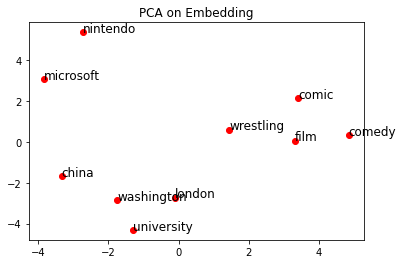

In [17]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

def plot_some_data():
    # pick some words to visualise
    words = ['film','washington','comedy','university','wrestling','london','china','microsoft','comic','nintendo']
    
    # retrieve the trained embeddings
    coords = [embedding_keyedvectors[word] for word in words]
    

    # perform PCA to reduce our Nd embeddings to 2d points that can be plotted
    pca = PCA(n_components=2)
    pca_result = pca.fit_transform(coords) # .t() transpose the embeddings
    
    for i,(x,y) in enumerate(pca_result):
        plt.plot(x, y, 'ro')
        plt.text(x, y, words[i], fontsize=12) # add a point label, shifted wrt to the point
    plt.title('PCA on Embedding')
    plt.show()
    
plot_some_data()

In [18]:
def create_embedding_from_keyedvectors(keyedvectors, freeze = False):
    vectors = keyedvectors.vectors
    padding_idx = vectors.shape[0]
    # pad vector is all zeros
    pad = np.zeros((1, vectors.shape[1]))
    # unk vector is the mean vector
    unk = np.mean(vectors, axis=0, keepdims=True)
    # concatenate
    weights = torch.FloatTensor( np.concatenate((vectors,pad,unk)) )
    return torch.nn.Embedding.from_pretrained(weights, padding_idx=padding_idx, freeze=freeze)

In [19]:
embedding_layer = create_embedding_from_keyedvectors(embedding_keyedvectors, freeze = True)

In [20]:
embedding_layer.num_embeddings, embedding_layer.embedding_dim

(400002, 300)

In [22]:
def create_vocabulary_from_keyedvectors(keyedvectors, globalParams):
    index_to_key = keyedvectors.index_to_key.copy()
    key_to_index = keyedvectors.key_to_index.copy()
    
    index_to_key.append(globalParams['PAD_TOKEN'])
    index_to_key.append(globalParams['UNK_TOKEN'])

    key_to_index[globalParams['PAD_TOKEN']] = len(key_to_index)
    key_to_index[globalParams['UNK_TOKEN']] = len(key_to_index)

    return {'key_to_index':key_to_index, 'index_to_key':index_to_key}

In [23]:
vocabulary = create_vocabulary_from_keyedvectors(embedding_keyedvectors, globalParams)

In [24]:
vocabulary['index_to_key'][-2], vocabulary['index_to_key'][-1]

('<pad>', '<unk>')

In [25]:
vocabulary['key_to_index'][globalParams['PAD_TOKEN']], vocabulary['key_to_index'][globalParams['UNK_TOKEN']]

(400000, 400001)

# Dataset

In [26]:
from NERDataset import NERDataset

In [27]:
dataset_train = NERDataset(data_train_path, vocabulary = vocabulary, params = globalParams)
dataset_dev = NERDataset(data_dev_path, vocabulary = None, params = globalParams)

In [28]:
dataset_train.save_labels( os.path.join(models_saves_path,'dataset_labels.npy') )

/home/marco/miniconda3/envs/nlp2022-hw1/lib/python3.9/site-packages/numpy/lib/npyio.py:528: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = np.asanyarray(arr)


In [29]:
dataset_train.save_vocabulary( os.path.join(models_saves_path,'dataset_vocabulary.npy') )

Creating the Dataloader:

In [30]:
BATCH_SIZE = 32
EPOCHS = 200

In [31]:
prepare_batch = NERDataset.prepare_batch_fn(dataset_train.vocabulary, dataset_train.label2id, globalParams['UNK_TOKEN'])

In [32]:
from torch.utils.data import DataLoader

dataloader_train = DataLoader(dataset_train, batch_size=BATCH_SIZE, shuffle=True, collate_fn=prepare_batch)
dataloader_dev = DataLoader(dataset_dev, batch_size=BATCH_SIZE, shuffle=False, collate_fn=prepare_batch)

In [33]:
for x in dataloader_dev:
    generic_element = x
    break
np.array(generic_element['inputs']).shape # (batch_size, window_size)

(32, 41)

In [77]:
print('Input')
print(generic_element['inputs'][0])
print('Output')
print(generic_element['outputs'][0])

Input
tensor([    13,      0,    122,      3,      0,   3160,    785,   9414,   4606,
           145,   3385, 400001,     69,     38,     40,   1315,   2141,      2,
        400000, 400000, 400000, 400000, 400000, 400000, 400000, 400000, 400000,
        400000, 400000, 400000, 400000, 400000, 400000, 400000, 400000, 400000,
        400000, 400000, 400000, 400000, 400000])
Output
tensor([12, 12, 12, 12, 12, 12,  4, 10, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12,
        -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
        -1, -1, -1, -1, -1])


In [78]:
input_size = len(vocabulary['key_to_index']) # how many different words?
input_length_train = max([len(sentence_list['inputs']) for sentence_list in dataset_train]) # maximum length of sentence
input_length_dev = max([len(sentence_list['inputs']) for sentence_list in dataset_dev]) # maximum length of sentence (dev)
n_labels = len(dataset_train.label2id)

print('input_size: ', input_size, '\nmax input_length train: ', input_length_train, '\nmax input_length dev: ', input_length_dev, '\nn_labels: ', n_labels)

input_size:  400002 
max input_length train:  41 
max input_length dev:  41 
n_labels:  13


In [79]:
globalParams['embedding_shape'] = ( embedding_layer.num_embeddings , embedding_layer.embedding_dim )
globalParams['n_labels'] = n_labels

# The Model

In [14]:
from NERNet import NERNet

In [34]:
load_model = True

if load_model:
    print('Loading weights...')
    model = NERNet(custom_embedding_layer=embedding_layer, output_size=len(dataset_train.id2label), device=device)
    model.load_weights(os.path.join(models_saves_path, 'nernet_weights.pth'))
    print('Loaded')
else:
    model = NERNet(custom_embedding_layer=embedding_layer, output_size=len(dataset_train.id2label), device=device)

Loading weights...
Loaded


In [35]:
from torchinfo import summary

summary(model, 
        input_size=(BATCH_SIZE, globalParams['window_size']), 
        dtypes=[torch.int64],
        col_names=["kernel_size", "output_size", "num_params"])

Layer (type:depth-idx)                   Kernel Shape              Output Shape              Param #
NERNet                                   --                        --                        --
├─Embedding: 1-1                         [300, 400002]             [32, 41, 300]             (120,000,600)
├─LSTM: 1-2                              --                        [32, 41, 160]             399,360
├─Linear: 1-3                            [160, 13]                 [32, 41, 13]              2,093
Total params: 120,402,053
Trainable params: 401,453
Non-trainable params: 120,000,600
Total mult-adds (G): 4.36
Input size (MB): 0.01
Forward/backward pass size (MB): 4.96
Params size (MB): 481.61
Estimated Total Size (MB): 486.58

# Training Phase

Using the optimizer:

In [82]:
import torch.optim as optim

loss_function = torch.nn.CrossEntropyLoss(ignore_index=globalParams['PAD_INDEX']) # !
optimizer = optim.SGD(model.parameters(), lr=0.0016, momentum=0.9)

This training function was taken and modified from the notebook #5:

In [39]:
def train_and_evaluate(
    model: torch.nn.Module,
    loss_function,
    optimizer: torch.optim.Optimizer,
    train_dataloader: DataLoader,
    valid_dataloader: DataLoader = None,
    epochs: int = 5,
    verbose: bool = True,
    device = 'cpu'
):

    train_history = []
    valid_history = []
    
    model.to(device)

    for epoch in range(epochs):
        losses = []
        
        model.train()

        # batches of the training set
        for step, sample in enumerate(train_dataloader):
            inputs = sample['inputs'].to(device)
            labels = sample['outputs']
            
            optimizer.zero_grad()
            predictions = model(inputs)
            
            predictions = predictions.view(-1, predictions.shape[-1]).to(device) # (batch , sentence , n_labels) -> (batch*sentence , n_labels)
            
            labels = labels.view(-1).to(device) # (batch , sentence) -> (batch*sentence)
            
            sample_loss = loss_function(predictions, labels)
            sample_loss.backward()
            optimizer.step()
            losses.append(sample_loss.item())
            

        mean_loss = sum(losses) / len(losses)
        train_history.append(mean_loss)
        
        if verbose or epoch == epochs - 1:
            print(f'  Epoch {epoch:3d} => avg_loss: {mean_loss:0.6f}')
        
        if valid_dataloader:
            valid_loss = evaluate(model, valid_dataloader, loss_function, device)
            valid_history.append(valid_loss)
            if verbose:
                print(f'    Validation avg_loss => {valid_loss:0.6f}')
                print()
                
        ''''''
    return {'train_history':train_history, 'valid_history':valid_history}

def evaluate(model, valid_dataset, loss_function, device):
    valid_loss = 0.0
    model.to(device)
    # set dropout to 0!! Needed when we are in inference mode.
    model.eval()
    with torch.no_grad():
        for sample in valid_dataset:
            inputs = sample['inputs'].to(device)
            labels = sample['outputs']

            predictions = model(inputs)
            
            predictions = predictions.view(-1, predictions.shape[-1]).to(device)
            labels = labels.view(-1).to(device)

            sample_loss = loss_function(predictions, labels)
            valid_loss += sample_loss.tolist()

    return valid_loss / len(valid_dataset)

In [216]:
train_model = False

if train_model:
    history = train_and_evaluate(model, loss_function, optimizer, dataloader_train, dataloader_dev, epochs=EPOCHS, verbose=True, device=device)

  Epoch   0 => avg_loss: 1.172766
    Validation avg_loss => 0.943896

  Epoch   1 => avg_loss: 0.936410
    Validation avg_loss => 0.923961

  Epoch   2 => avg_loss: 0.917920
    Validation avg_loss => 0.905708

  Epoch   3 => avg_loss: 0.900236
    Validation avg_loss => 0.886654

  Epoch   4 => avg_loss: 0.881106
    Validation avg_loss => 0.865930

  Epoch   5 => avg_loss: 0.858738
    Validation avg_loss => 0.843008

  Epoch   6 => avg_loss: 0.835229
    Validation avg_loss => 0.819034

  Epoch   7 => avg_loss: 0.811431
    Validation avg_loss => 0.795516

  Epoch   8 => avg_loss: 0.788932
    Validation avg_loss => 0.774273

  Epoch   9 => avg_loss: 0.768930
    Validation avg_loss => 0.756172

  Epoch  10 => avg_loss: 0.752849
    Validation avg_loss => 0.740763

  Epoch  11 => avg_loss: 0.738090
    Validation avg_loss => 0.727322

  Epoch  12 => avg_loss: 0.725736
    Validation avg_loss => 0.715174

  Epoch  13 => avg_loss: 0.713863
    Validation avg_loss => 0.703499

  Epoc

# Saving...

In [320]:
if train_model:
    model.save_weights(os.path.join(models_saves_path,'nernet_weights.pth'))

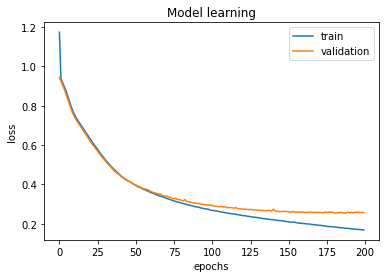

In [218]:
import matplotlib.pyplot as plt

if train_model:
    plt.plot([i for i in range(len(history['train_history']))], history['train_history'], label='train')
    plt.plot([i for i in range(len(history['valid_history']))], history['valid_history'], label='validation')
    plt.xlabel('epochs')
    plt.ylabel('loss')
    plt.title('Model learning')
    plt.legend()
    plt.show()

# Evaluating metrics...

In [219]:
def remove_indices_from_lists(y_pred, y_true, black_list):
    '''
    Removes from y_pred and y_true the values contained in black_list that matches with y_true
    '''
    y_pred_refined, y_true_refined = [], []
    for p,l in zip(y_pred, y_true):
        if l not in black_list:
            y_pred_refined.append(p) 
            y_true_refined.append(l)
    return y_pred_refined, y_true_refined

def obtain_pred_labels(model, valid_dataset, device):
    model.to(device)
    model.eval() # dropout to 0

    y_true_total = []
    y_pred_total = []
    
    with torch.no_grad():
        for sample in valid_dataset:
            inputs = sample['inputs'].to(device)
            y_true = sample['outputs']

            y_pred = model(inputs)
            y_pred = model.get_indices(y_pred)
            
            y_pred_total.append(y_pred.view(-1))
            y_true_total.append(y_true.view(-1))

    y_pred, y_true = torch.cat(y_pred_total, dim=0).cpu().numpy(), torch.cat(y_true_total, dim=0).cpu().numpy()
    y_pred, y_true = remove_indices_from_lists(y_pred, y_true, [-1])
    return y_pred, y_true

In [220]:
y_pred, y_true = obtain_pred_labels(model, dataloader_dev, device)

In [221]:
from sklearn.metrics import classification_report

print( classification_report(y_true, y_pred, target_names=dataset_train.id2label) )

              precision    recall  f1-score   support

      B-CORP       0.74      0.56      0.64       133
        B-CW       0.54      0.46      0.50       170
       B-GRP       0.75      0.65      0.70       189
       B-LOC       0.81      0.80      0.81       243
       B-PER       0.88      0.86      0.87       300
      B-PROD       0.56      0.42      0.48       149
      I-CORP       0.72      0.61      0.66       119
        I-CW       0.59      0.67      0.63       261
       I-GRP       0.82      0.79      0.80       376
       I-LOC       0.73      0.77      0.75       153
       I-PER       0.87      0.90      0.89       329
      I-PROD       0.50      0.57      0.53        87
           O       0.96      0.97      0.97     10230

    accuracy                           0.92     12739
   macro avg       0.73      0.70      0.71     12739
weighted avg       0.92      0.92      0.92     12739



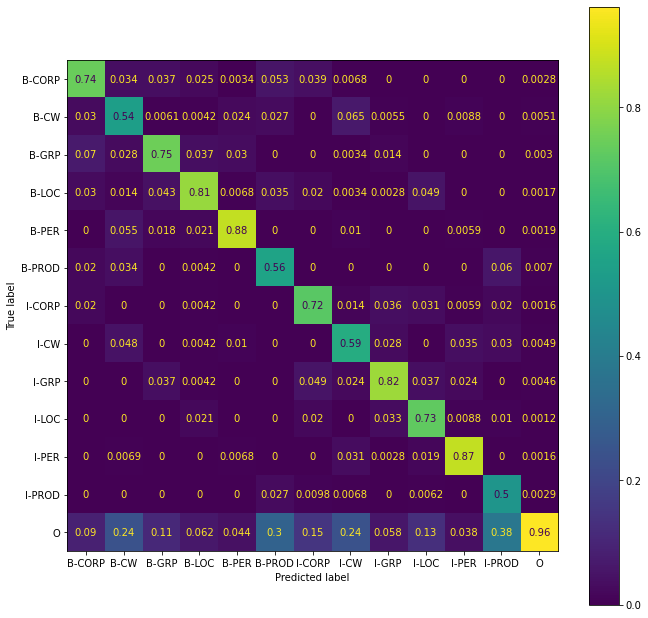

In [222]:
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix

cm = confusion_matrix(y_true, y_pred, normalize='pred') # normalized over predicted label: the sum of each column is 1
cmd = ConfusionMatrixDisplay(cm, display_labels=dataset_train.id2label)
fig, ax = plt.subplots(figsize=(11,11))
cmd.plot(ax=ax)

# Testing usability...

In [91]:
from FinalModel import FinalModel
student = FinalModel(models_saves_path)

Creating student...
Loading model...
Init done


In [22]:
data_eval_input = []
data_eval_label = []
for sentence in NERDataset.read_dataset(data_dev_path):
    data_eval_input.append(sentence['inputs'])
    data_eval_label.append(sentence['outputs'])

In [23]:
data_eval_predict = student.predict(data_eval_input)

In [24]:
y_true_sample = ['B-PER','I-PER','O','B-CORP','O','O','O','O','B-LOC','I-LOC','O']
input_sample = ['John','Lucas','joined','Aiimi','as','data','scientist','in','New','York','.']

print( student.predict([input_sample]) )

[['B-PER', 'I-PER', 'O', 'O', 'O', 'O', 'O', 'O', 'B-LOC', 'I-GRP', 'O']]


In [26]:
from seqeval.metrics import accuracy_score, f1_score

acc = accuracy_score(data_eval_label, data_eval_predict)
f = f1_score(data_eval_label, data_eval_predict, average="macro")

print(f"# accuracy: {acc:.4f}")
print(f"# f1: {f:.4f}")

# accuracy: 0.9205
# f1: 0.5689


With these values, I can see an increment of around 20% in f1 score w.r.t the FastText implementation. The result is that a bigger vocabulary is better than a smaller one but with lots of n-grams in order to deal with OOV words. In order to deal with them, a different approach could be tried in the next test, which is applying Conditional Random Field in the last layer of the network.

Testing a long phrase...

In [98]:
long_sample = [ 'childhood', 'friends', 'bill', 'gates', 'and', 'paul', 'allen', 'sought', 'to', 'make', 'a', 'business', 'using', 'their', 'skills', 'in', 'computer', 
                'programming.', 'in', '1972,', 'they', 'founded', 'traf-o-data,', 'which', 'sold', 'a', 'rudimentary', 'computer', 'to', 'track', 'and', 'analyze', 
                'automobile', 'traffic', 'data', '.', 'gates', 'enrolled', 'at', 'harvard', 'university', 'while', 'allen', 'pursued', 'a', 'degree', 'in', 'computer', 
                'science', 'at', 'washington', 'state', 'university', ',', 'though', 'he', 'later', 'dropped', 'out', 'to', 'work', 'at', 'honeywell', '.', 'the', 'january', 
                '1975', 'issue', 'of', 'popular', 'electronics', 'featured', 'micro', 'instrumentation', 'and', 'telemetry', "systems", '(', 'mits', ')', 'altair', '8800', 'microcomputer']
long_sample_predictions = student.predict([long_sample])
print(len(long_sample), len(long_sample_predictions[0]))
print(list(zip(long_sample,long_sample_predictions[0])))

83 83
[('childhood', 'O'), ('friends', 'O'), ('bill', 'B-PER'), ('gates', 'O'), ('and', 'O'), ('paul', 'B-PER'), ('allen', 'I-PER'), ('sought', 'O'), ('to', 'O'), ('make', 'O'), ('a', 'O'), ('business', 'O'), ('using', 'O'), ('their', 'O'), ('skills', 'O'), ('in', 'O'), ('computer', 'O'), ('programming.', 'O'), ('in', 'O'), ('1972,', 'O'), ('they', 'O'), ('founded', 'O'), ('traf-o-data,', 'O'), ('which', 'O'), ('sold', 'O'), ('a', 'O'), ('rudimentary', 'O'), ('computer', 'O'), ('to', 'O'), ('track', 'O'), ('and', 'O'), ('analyze', 'O'), ('automobile', 'O'), ('traffic', 'O'), ('data', 'O'), ('.', 'O'), ('gates', 'O'), ('enrolled', 'O'), ('at', 'O'), ('harvard', 'B-GRP'), ('university', 'I-GRP'), ('while', 'O'), ('allen', 'O'), ('pursued', 'O'), ('a', 'O'), ('degree', 'O'), ('in', 'O'), ('computer', 'O'), ('science', 'O'), ('at', 'O'), ('washington', 'B-GRP'), ('state', 'I-GRP'), ('university', 'I-GRP'), (',', 'O'), ('though', 'O'), ('he', 'O'), ('later', 'O'), ('dropped', 'O'), ('out', 

Saving global variables...

In [83]:
np.save(os.path.join(models_saves_path, 'global_params.npy'), globalParams)

In [13]:
globalParams = np.load(os.path.join(models_saves_path, 'global_params.npy'), allow_pickle=True).tolist()
globalParams

{'PAD_TOKEN': '<pad>',
 'PAD_INDEX': -1,
 'UNK_TOKEN': '<unk>',
 'window_size': 41,
 'window_shift': 33,
 'embedding_shape': (400002, 300),
 'n_labels': 13}